# TODOs
* Add Bayesian model

# Imports etc.

In [1]:
import ipdb
import numpy as np
import os
import pandas as pd
import plotnine as gg
import scipy
gg.theme_set(gg.theme_bw)

In [2]:
fitted_param_dir = 'C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice/'
plot_dir = 'C:/Users/maria/MEGAsync/SLCN/models/plots'
mouse_data_dir = 'C:/Users/maria/MEGAsync/SLCN/PSMouseData'

# Functions to simulate data

In [3]:
class PSAgent():
    
    def __init__(self, n_agents, params, init_Q, eps=1e-5):
        self.n_agents = n_agents
        self.params = params
        self.avail_actions = (0, 1)
        self.init_Q = init_Q
        self.Q = init_Q * np.ones((n_agents, len(self.avail_actions)))
        self.eps = eps
        self.prev_action = np.full(n_agents, np.nan)
        
    def take_action(self):
        """
        Take 1 action per agent, based on current trial Q-values.
        """
        
        ags = np.arange(self.n_agents)

        # Perseveration
        Q0 = self.Q[ags, 0]
        Q1 = self.Q[ags, 1]
        if not np.isnan(self.prev_action[0]):  # prev_action is np.nan on trial 0 only; only checking first element for simplicity
            Q0 += (1 - self.prev_action) * self.params['persev'].values  # action 0: subtract persev when repeating
            Q1 += self.prev_action * self.params['persev'].values   # action 1: add persev when repeating

        # Action selection
        lik = scipy.special.softmax(self.params['beta'].values * np.array([Q0, Q1]).T, axis=1)
        action = np.array([np.random.choice(self.avail_actions, p=lik[a]) for a in range(self.n_agents)])
        self.prev_action = action.copy()
        
#         lik = self.eps / 2 + (1 - self.eps) + lik  # squeeze between eps and 1-eps to avoid 0's and 1's
        
        return lik, action
    
    def update_Q(self, action, reward):
        """
        Update Q-values based on RL.
        """
        
        ags = np.arange(self.n_agents)
        
        rpe = (1 - self.Q[ags, action]) * reward  # received reward, updating chosen action
        nrpe = (0 - self.Q[ags, action]) * (1 - reward)  # received no reward, updating chosen action
        
        crpe = (0 - self.Q[ags, 1-action]) * reward  # received reward, updating unchosen action
        cnrpe = (1 - self.Q[ags, 1-action]) * (1 - reward)  # received no reard, updating unchosen action
        
        self.Q[ags, action] += self.params['alpha'].values * rpe + self.params['nalpha'].values * nrpe
        self.Q[ags, 1-action] += self.params['calpha'].values * crpe + self.params['cnalpha'].values * cnrpe


# Example use:
params = pd.DataFrame({
    'alpha': [0.8], 'nalpha': [0.1], 'calpha': [0.9], 'cnalpha': [0.1],
    'beta': [4], 'persev': [0.2], 'bias': [0]
})
init_Q = 1/2
n_agents = 10

agent = PSAgent(n_agents, params, init_Q)
lik, action = agent.take_action()
print("action", action)
# correct, reward = task.present_reward(action, trial)
# print("reward", reward)
# agent.update_Q(action, reward)
# print("agent.Q", agent.Q)

action [0 1 1 1 1 1 1 0 1 0]


In [4]:
class PSTask():
    
    def __init__(self, p_cor, correct_actions, n_trials, block_lengths_lower, block_lengths_upper):
        """
        Must either provide block_lengths_lower and block_lengths_upper -> task will be created on the fly;
        or correct_actions -> provided task will be used.
        """
        
        self.p_cor = p_cor

        if len(correct_actions) > 0:
            self.correct_actions = correct_actions
            self.n_trials = len(correct_actions)
        elif block_lengths_lower: 
            self.block_lengths_lower = block_lengths_lower
            self.block_lengths_upper = block_lengths_upper
            self.n_trials = n_trials
            self.correct_actions = self.make_task()
        else:
            raise ValueError("You must provide either correct_actions or block_lengths_lower.")
        
    def make_task(self):
        """
        Currently just produces the same sequence of correct and incorrect boxes for each animal.
        In future, will read in animal data.
        """
        
        correct_actions = []
        block_lengths = np.random.randint(
            low=self.block_lengths_lower, high=self.block_lengths_upper, size=self.n_trials)

        for block_length, correct_side in zip(block_lengths, [0, 1] * self.n_trials):
            correct_actions += block_length * [correct_side]
        
        correct_actions = correct_actions[:self.n_trials]
        
        return correct_actions
        
    def get_chance_rewards(self, n_correct_choices):
        """
        Translate accuracy into rewards:
        Return '1' with probability self.p_cor and '0' with probability 1-self.p_cor, for each agent.
        """
        
        return np.array([np.random.choice((0, 1), p=(1-self.p_cor, self.p_cor)) for i in range(n_correct_choices)])

    def present_reward(self, action, trial):
        """
        Present reward (0, 1) for each agent in this trial, based on choices,
        by consulting the correct_box on the current trial.
        """
        
        correct = np.array(self.correct_actions[trial] == action).astype(int)
        reward = correct.copy()
        reward[reward == 1] = self.get_chance_rewards(sum(reward==1))
        
        return correct, reward
    
# Example use
n_trials = 200
p_cor = 0.75
block_lengths_lower = 40
block_lengths_upper = 41

task = PSTask(
    p_cor, n_trials=n_trials, block_lengths_lower=block_lengths_lower, block_lengths_upper=block_lengths_upper,
    correct_actions=[])
task.make_task()

task.get_chance_rewards(n_correct_choices=100)

action = np.zeros(n_agents)
trial = 0
task.present_reward(action, trial)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([0, 0, 1, 1, 0, 1, 1, 1, 1, 1]))

In [5]:
def simulate_dataset(task_args, agent_args, suff=''):
    
    actions = []
    liks = []
    rewards = []
    corrects = []

    # Get task and agent
    task = PSTask(task_args['p_cor'], n_trials=task_args['n_trials'],
                  block_lengths_lower=task_args['block_lengths_lower'], block_lengths_upper=task_args['block_lengths_upper'],
                  correct_actions=task_args['correct_actions'])
    agent = PSAgent(agent_args['n_agents'], agent_args['params'], agent_args['init_Q'])

    # Play the game, save data
    for trial in range(n_trials):

        lik, action = agent.take_action()
        correct, reward = task.present_reward(action, trial)
        agent.update_Q(action, reward)

        actions += [action]
        liks += [lik]
        rewards += [reward]
        corrects += [correct]

    # Format data
    data = pd.DataFrame(
            {'action' + suff: actions, 'lik' + suff: liks,
             'reward' + suff: rewards, 'correct' + suff: corrects, 'correct_action': task.correct_actions})
    data = data.reset_index()
    data = data.rename(columns={'index': 'trial'})

    data['mean_reward'] = np.mean(np.array(list(data['reward' + suff])), axis=1)
    data['mean_correct'] = np.mean(np.array(list(data['correct' + suff])), axis=1)
    data['block'] = np.append([0], np.cumsum(np.abs(np.diff(task.correct_actions))))

    return data

# Example use
task_args = {
    'p_cor': 0.75, 'correct_actions': [], 'n_trials': n_trials,
    'block_lengths_lower': block_lengths_lower, 'block_lengths_upper': block_lengths_upper
}
agent_args = {
    'n_agents': n_agents, 'params': params, 'init_Q': init_Q,
}

data = simulate_dataset(task_args, agent_args)
data

,trial,action,lik,reward,correct,correct_action,mean_reward,mean_correct,block
0,0,"[1, 0, 0, 1, 0, 0, 1, 1, 1, 1]","[[0.49999999999999994, 0.49999999999999994], [...","[0, 1, 1, 0, 0, 1, 0, 0, 0, 0]","[0, 1, 1, 0, 1, 1, 0, 0, 0, 0]",0,0.3,0.4,0
1,1,"[1, 0, 0, 0, 1, 0, 1, 1, 1, 1]","[[0.401312339887548, 0.5986876601124519], [0.9...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 1, 1, 0, 1, 0, 0, 0, 0]",0,0.2,0.4,0
2,2,"[1, 0, 0, 0, 1, 0, 1, 1, 0, 1]","[[0.49000133312003463, 0.5099986668799653], [0...","[0, 1, 1, 0, 0, 1, 0, 0, 1, 0]","[0, 1, 1, 1, 0, 1, 0, 0, 1, 0]",0,0.4,0.5,0
3,3,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 1]","[[0.5705266031962989, 0.4294733968037012], [0....","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 0, 0, 1, 0, 1, 1, 0]",0,0.3,0.6,0
4,4,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 1]","[[0.9874151890256736, 0.012584810974326273], [...","[1, 0, 1, 1, 1, 1, 0, 1, 1, 0]","[1, 1, 1, 1, 1, 1, 0, 1, 1, 0]",0,0.7,0.8,0
...,...,...,...,...,...,...,...,...,...
195,195,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[0.9918374256609561, 0.008162574339044113], [...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0,1.0,1.0,4
196,196,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[[0.9918374282102799, 0.008162571789720645], [...","[1, 0, 1, 1, 1, 0, 1, 0, 0, 1]","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1]",0,0.6,0.9,4
197,197,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[0.9918374287195896, 0.008162571280410438], [...","[1, 0, 1, 0, 1, 0, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0,0.7,1.0,4
198,198,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[0.9918374288213958, 0.008162571178603846], [...","[1, 0, 0, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0,0.8,1.0,4


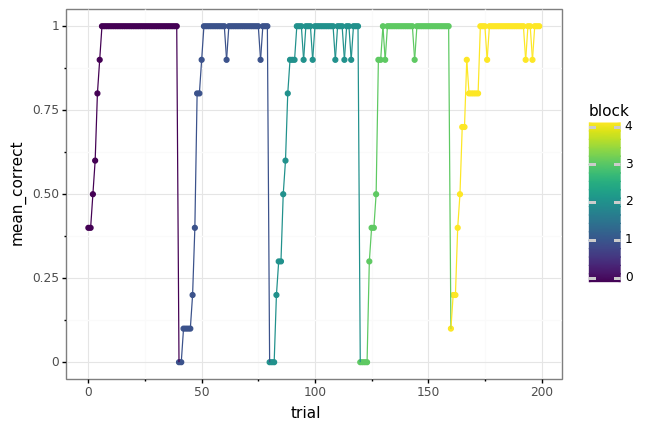

<ggplot: (137856518909)>

In [6]:
(gg.ggplot(data, gg.aes('trial', 'mean_correct', color='block'))
 + gg.geom_point()
 + gg.geom_line()
)

# Putting it all together

## Get true mouse data for IDs and action sequences

In [7]:
fullID_j = pd.read_csv(os.path.join(mouse_data_dir, 'Juvi_AnimalID.csv')).T.values.flatten()
fullID_a = pd.read_csv(os.path.join(mouse_data_dir, 'Adult_AnimalID.csv')).T.values.flatten()
fullIDs = np.concatenate([fullID_j, fullID_a])
animals = [int(str(fullID)[:-5]) for fullID in fullIDs]
ages = [int(str(fullID)[-5:-2]) for fullID in fullIDs]
true_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_mouse_data.csv'))
true_dat

,Unnamed: 0,action,reward,correct,correct_action,trial,block,fullID,animal,age,gender,agegroup,rew_1ago,rew_2ago,switch,block_length,block_trial,trials2switch,session,rew_12ago
0,0,0,0,0,1,0,0,1404012,14,40,1,2,NaN,NaN,NaN,12.0,0.0,0.0,0.0,nn
1,1,0,0,0,1,1,0,1404012,14,40,1,2,0.0,NaN,0.0,12.0,1.0,1.0,0.0,0n
2,2,1,1,1,1,2,0,1404012,14,40,1,2,0.0,0.0,1.0,12.0,2.0,2.0,0.0,00
3,3,1,1,1,1,3,0,1404012,14,40,1,2,1.0,0.0,0.0,12.0,3.0,3.0,0.0,10
4,4,1,1,1,1,4,0,1404012,14,40,1,2,1.0,1.0,0.0,12.0,4.0,4.0,0.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319720,720,1,1,1,1,720,30,1309021,13,90,2,1,0.0,0.0,1.0,20.0,16.0,16.0,18.0,00
319721,721,1,1,1,1,721,30,1309021,13,90,2,1,1.0,0.0,0.0,20.0,17.0,-3.0,18.0,10
319722,722,1,1,1,1,722,30,1309021,13,90,2,1,1.0,1.0,0.0,20.0,18.0,-2.0,18.0,11
319723,723,1,1,1,1,723,30,1309021,13,90,2,1,1.0,1.0,0.0,20.0,19.0,-1.0,18.0,11


## Get fitted params

In [8]:
fitted_params = pd.DataFrame()
modelnames = [f for f in os.listdir(fitted_param_dir) if ('.csv' in f) and ('params' in f) and ('B' not in f)]
for modelname in modelnames:
    model_params = pd.read_csv(os.path.join(fitted_param_dir, modelname))
    model_params['model'] = modelname.split('_')[1]
    fitted_params = fitted_params.append(model_params, sort=False)
fitted_params

,beta,persev,bias,alpha,nalpha,calpha,sID,slope_variable,fullID,animal,PreciseYrs,Gender,treatment,session,age_z,T1,PDS,cnalpha,model
0,4.001923,0.0,-0.012627,0.557041,0.557041,0.995909,1404012,age_z,1404012,14,40,Male,2,0,-1.052255,0,0,0.0,RLabcd
1,3.244827,0.0,-0.121699,0.757806,0.757806,0.544451,1404112,age_z,1404112,14,41,Male,2,1,-0.997610,0,0,0.0,RLabcd
2,2.641660,0.0,-0.188767,0.754289,0.754289,0.965519,1404212,age_z,1404212,14,42,Male,2,2,-0.942965,0,0,0.0,RLabcd
3,5.884683,0.0,0.021574,0.833060,0.833060,0.988089,1404312,age_z,1404312,14,43,Male,2,3,-0.888320,0,0,0.0,RLabcd
4,4.781250,0.0,-0.026208,0.696400,0.696400,0.222582,1404412,age_z,1404412,14,44,Male,2,4,-0.833675,0,0,0.0,RLabcd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,4.244474,0.0,0.000000,0.816118,0.816118,0.000000,1308521,age_z,1308521,13,85,Female,1,11,1.406765,0,0,0.0,RLab
436,5.005828,0.0,0.000000,0.757376,0.757376,0.000000,1308621,age_z,1308621,13,86,Female,1,12,1.461410,0,0,0.0,RLab
437,3.570965,0.0,0.000000,0.654044,0.654044,0.000000,1308821,age_z,1308821,13,88,Female,1,13,1.570700,0,0,0.0,RLab
438,5.105522,0.0,0.000000,0.794029,0.794029,0.000000,1308921,age_z,1308921,13,89,Female,1,14,1.625345,0,0,0.0,RLab


### Plot fitted params

In [9]:
fitted_params_ = fitted_params.copy()
fitted_params_['beta'] /= 20
fitted_params_long = fitted_params_.melt(
    id_vars=['sID', 'slope_variable', 'fullID', 'animal', 'PreciseYrs', 'Gender', 'treatment',
             'session', 'age_z', 'T1', 'PDS', 'model'],
    value_name='param_value', var_name='param'
)

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\fitted_params.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


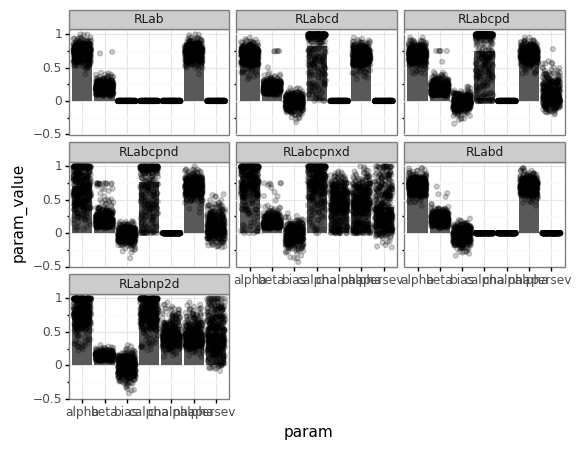

In [10]:
g = (gg.ggplot(fitted_params_long, gg.aes('param', 'param_value'))
 + gg.stat_summary(geom='bar')
 + gg.geom_point(position='jitter', alpha=0.2)
 + gg.facet_wrap('~ model')
)
g.draw()
g.save(os.path.join(plot_dir, 'fitted_params.png'))

## Simulate all RL models

In [11]:
param_names = ['alpha', 'nalpha', 'calpha', 'cnalpha', 'beta', 'persev', 'bias']
n_agents = 10

In [ ]:
model_names = [modelname.split('_')[1] for modelname in modelnames]
for model_name in model_names:
    print(model_name, model_names)
    sim_data = pd.DataFrame()
    
    for animal, age, fullID in zip(animals, ages, fullIDs):
        if (animal != 23) and (age != 43):  # Error in the Juvi_AnimalID.csv - rerunning fitted_params with fixed one

            # Get task for this mouse
            true_sub = true_dat.loc[(true_dat.age == age) & (true_dat.animal == animal)]
            n_trials = len(np.unique(true_sub.trial))
            correct_actions = true_sub.correct_action.values

            # Get params
            params = fitted_params.loc[
                (fitted_params.PreciseYrs == age) & (fitted_params.animal == animal) & (fitted_params.model == model_name),
                param_names]
            task_args = {
                'p_cor': 0.75, 'correct_actions': correct_actions, 'n_trials': 0,
                'block_lengths_lower': False, 'block_lengths_upper': False
            }
            agent_args = {
                'n_agents': n_agents, 'params': params, 'init_Q': init_Q
            }

            sub_data = simulate_dataset(task_args, agent_args, suff='all')
            sub_data['session'] = true_sub.session
            sub_data['animal'] = animal
            sub_data['age'] = age
            sub_data['fullID'] = fullID
            sub_data['model'] = model_name

            sim_data = sim_data.append(sub_data)
    
    save_dir = os.path.join(fitted_param_dir, 'simulations/simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents))
    print("Saving sim_data ({}) to {}...".format(sim_data.shape, save_dir))
    sim_data.to_csv(save_dir, index=False)

RLabcd ['RLabcd', 'RLabcpd', 'RLabcpnd', 'RLabcpnxd', 'RLabd', 'RLabnp2d', 'RLab']


### Basic check that simulated behavior looks reasonable

In [ ]:
gg.options.figure_size = (10, 10)
(gg.ggplot(sim_data, gg.aes('trial', 'mean_correct', color='gender'))
 + gg.stat_summary()
)